In [6]:
import cvxopt
import quadprog
import numpy as np
from numpy.linalg import inv
from cvxopt import matrix, solvers
from scipy.linalg import block_diag
import random
import qp_matrix
import matplotlib.pyplot as plt

In [7]:
# CVXOPT solver
def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = .5 * (P + P.T)  # make sure P is symmetric
    args = [matrix(P), matrix(q)]
    if G is not None:
        args.extend([matrix(G), matrix(h)])
        if A is not None:
            args.extend([matrix(A), matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((P.shape[1],))

In [8]:
def kinematics(x_init, y_init, theta_init, v,omega, dt):
    x = x_init+v*np.cos(theta_init)*dt
    y = y_init+v*np.cos(theta_init)*dt
    theta = theta_init+omega*dt
    return x,y,theta

In [24]:
## MPC Solver
def MPC_solver_scx(init_pose,curr_pose,final_pose,obstacle,state,x_vel_limit,y_vel_limit,Np,Nc,dt):
    # Initialize at step i
    x_origin = y_origin = 0
    x_limit = y_limit = 200 # box constraints?
    x_init, y_init, theta_init = init_pose
    x_curr, y_curr, theta_curr = curr_pose
    x_final, y_final, theta_final = final_pose
    x_obs, y_obs, r_obs = obstacle
    x_actual = x_final - x_curr # What is x_actual?
    y_actual = y_final - y_curr
    iteration = 0
    d=1000
    delta = 0.5
    ## Equality and Inequality Constraint Matrices formulation

    # Declare Variable List
    A_eq_d=b_eq_d=A_ineq_d=B_ineq_d=big_H=big_h= np.empty(2) #formulate boundary inequalities and equalities (position & velocities)
    big_I = big_0= big_A_eq= dyn_A= dyn_b= term_A= term_b= x_pos_constraint= x_vel_constraint = np.empty(2)

    big_I = np.eye(2*Np)
    big_0 = np.zeros(2*Np)
    
    # Dynamic constraints
    dyn_A = np.column_stack((np.eye(Np, dtype=float) + np.eye(Np, Np , 1, dtype=float) * -1, np.eye(Np, dtype=float) * dt))
    dyn_b = np.zeros(Np, dtype=float)
    
    # Terminal LHS constraints
    term_A = np.zeros((2*Np), dtype=float)
    
    #Concatenate dynamic and terminal LHS constraint
    x_A_eq = np.row_stack((dyn_A, term_A))
    
    # Terminal Constraints
    x_term_b = np.array([x_actual])
    y_term_b = np.array([y_actual])
    
    # Concatenate dynamic and terminal RHS constraint
    x_b_eq = np.concatenate((dyn_b, x_term_b))
    y_b_eq = np.concatenate((dyn_b, y_term_b))
    big_b_eq = np.concatenate((x_b_eq, y_b_eq))
    
    # Inequality constraints(Boundary constraints)
    pos_x_constraint = np.eye(Np) * -delta + np.eye(Np, Np, 1)
    neg_x_constraint = np.eye(Np) * delta - np.eye(Np, Np, 1)
    x_pos_constraint = np.row_stack( (pos_x_constraint, neg_x_constraint) )

    pos_y_constraint = np.eye(Np) * -delta + np.eye(Np, Np, 1)
    neg_y_constraint = np.eye(Np) * delta - np.eye(Np, Np, 1)
    y_pos_constraint = np.row_stack((pos_y_constraint, neg_y_constraint))

    pos_r_vel_constraint = pos_theta_vel_constraint = np.eye(Np)
    neg_r_vel_constraint = neg_theta_vel_constraint = np.eye(Np) * -1

    x_vel_constraint = np.row_stack((pos_r_vel_constraint, neg_r_vel_constraint))
    x_Ba_ineq = block_diag(x_pos_constraint, x_vel_constraint)
    y_vel_constraints = np.row_stack((pos_theta_vel_constraint, neg_theta_vel_constraint))
    y_Ba_ineq = block_diag(y_pos_constraint, y_vel_constraints)
    
    x_vel_limit_vec = np.ones(2 * Np) * x_vel_limit
    y_vel_limit_vec = np.ones(2 * Np) * y_vel_limit
    
    r_Bb_ineq = np.concatenate((np.ones(Np) * ((x_origin + x_limit) * (1 - delta)),
                                np.ones(Np) * (-(x_origin - x_limit) *  (1 - delta)), x_vel_limit_vec))
    
    theta_Bb_ineq = np.concatenate((np.ones(Np) * ((y_origin + y_limit) * (1 - delta)), 
                                    np.ones(Np) * (-(y_origin - y_limit) *  (1 - delta)), y_vel_limit_vec))
    big_Bb_ineq = np.concatenate((r_Bb_ineq, theta_Bb_ineq))
    
    # Relaxation
    big_H = block_diag([1000], big_I, [1000], big_I)
    big_h = np.concatenate(([0], big_0, [0], big_0))
    x_A_eq = np.column_stack((np.zeros(Np + 1), x_A_eq))
    x_A_eq[Np-1][0] = -1
    x_A_eq[Np][1] = 1
    y_A_eq = x_A_eq
    big_A_eq = block_diag(x_A_eq, y_A_eq)

    x_Ba_ineq = np.column_stack((np.transpose(np.zeros(np.size(x_Ba_ineq, 0))), x_Ba_ineq))
    x_Ba_ineq[Np-1][0] = 1
    x_Ba_ineq[2 * Np-1][0] = -1

    y_Ba_ineq = np.column_stack((np.transpose(np.zeros(np.size(y_Ba_ineq, 0))), y_Ba_ineq))
    y_Ba_ineq[Np-1][0] = 1
    y_Ba_ineq[2 * Np-1][0] = -1

    big_Ba_ineq = block_diag(x_Ba_ineq, y_Ba_ineq)
    
#     print(big_H)
#     print((big_h))
#     print('big_Ba_ineq = ',big_Ba_ineq)
#     print('big_Bb_ineq = ',big_Bb_ineq)
#     print((big_A_eq))
#     print((big_b_eq))
#     print(np.shape(big_H))
#     print(np.shape(big_h))
#     print('shape(big_Ba_ineq)',np.shape(big_Ba_ineq))
#     print('shape(big_Bb_ineq)',np.shape(big_Bb_ineq))
#     print(np.shape(big_A_eq))
#     print(np.shape(big_b_eq))
    
    print("state = ", state)
    x_obs = x_final - x_obs
    y_obs = y_final - y_obs
    while (d>0.1 and iteration<10):
#         iteration+=1
        iteration = iteration + 1
        barrier_cons_A = np.zeros((Np, 4 * Np + 2),dtype=float)
        barrier_cons_B = np.zeros((Np),dtype=float)
        
        x_in = state[1:Np+1]
        y_in = state[2 * Np + 2:2 * Np + 1 + Np + 1 ]
        
        A_ineq_d = big_Ba_ineq
        B_ineq_d = big_Bb_ineq - np.dot(A_ineq_d, state) #????

        A_eq_d = big_A_eq
        b_eq_d = big_b_eq - np.dot(big_A_eq, state) #????
        
        # SCx Algorithm - Np steps
        for i in range(1,Np):
            x_prev = x_in[i-1]
            y_prev = y_in[i-1]
            x = x_in[i]
            y = y_in[i]
            
            # if h is negative, mule is outside obstacle
            # if h is 0, mule is grazing the obstacle, if h is positive, mule is inside the obstacle region.
            h_prev = r_obs**2 - (x_prev-x_obs)**2 - (y_prev-y_obs)**2 # distance to obstacle in the last time instant
            h = r_obs**2 - (x-x_obs)**2 - (y-y_obs)**2 # distance to obstacle in the current time instant

            gamma = 0.2 #Discount factor
            
            # Obstacle Constraints 
            barrier_cons_A[i][i+1] = -2*(x-x_obs)
            barrier_cons_A[i][1 + 2 * Np + 1 + i] = -2*(y-y_obs)

            barrier_cons_A[i][i] = gamma * 2 * (x_prev - x_obs)
            barrier_cons_A[i][1 + 2 * Np + i] = gamma * 2 * (y_prev-y_obs)
            barrier_cons_B[i] = - h+gamma*h_prev
        
        A_ineq_d = np.vstack((A_ineq_d, barrier_cons_A))
        B_ineq_d = np.concatenate((B_ineq_d, barrier_cons_B))
        
#     print('big_H = ',big_H)
#     print('big_h = ',big_h)
    print('A_ineq_d = ',A_ineq_d)
    print('B_ineq_d = ',B_ineq_d)
    print('A_eq_d = ',A_eq_d)
    print('b_eq_d = ',b_eq_d)
    print('x_A_eq = ',x_A_eq)
#     d_state_out = cvxopt_solve_qp(big_H, big_h, A_ineq_d, B_ineq_d, A_eq_d, b_eq_d)
    d_state_out = qp_matrix.quadprog_solve_qp(big_H, big_h, A_ineq_d, B_ineq_d, A_eq_d, b_eq_d)
    
    state += d_state_out # state is getting updated here after the optimum solution is given by the solver.
    d = np.linalg.norm(state)
    
    return state[Np+1], state[3 *Np+2]

10


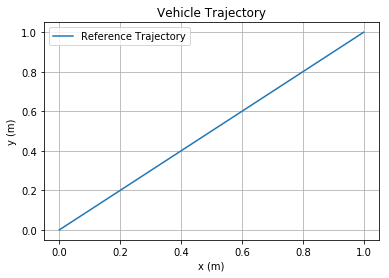

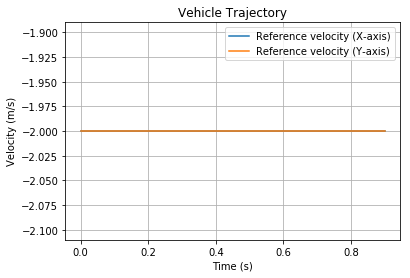

In [25]:
## Trajectory Formulation

# Initial Pose
init_pose = [0,0,np.pi/4]
# Final Pose
final_pose = [1,1,np.pi/4]
# Obstacle 
obstacle = [0.5,0.5,0.1] # x, y, radius

# MPC Parameters
Np = 3 # Not working for Np neq 1?!
Nc = 1
dt = 0.05 # Sample Time
t_final = 1
time = np.arange(0,t_final,dt*v_max)

# Input constraints
v_max = 2.0 # Forward velocity limit
v_min = 0 # Min Velocity
w_max = v_max/3 # Yaw rate limit
w_min = -v_max/3
# Velocity compoments
x_vel_limit = y_vel_limit= v_max # Vx_max, Vy_max
length=len(time)
# Planner Trajectory
speed = 1/t_final
print(length)
path_planner = np.zeros((length+Np,3),dtype=float).reshape(length+Np,3) # t_final
# path_planner[0:length,0]=np.arange(init_pose[0],final_pose[0],final_pose[0]/length)
path_planner[0:length,0]=np.arange(final_pose[0],init_pose[0],-v_max * dt)
# path_planner[0:length,1]=np.arange(init_pose[1],final_pose[1],final_pose[1]/length)
path_planner[0:length,1]=np.arange(final_pose[1],init_pose[1],-v_max * dt)
velocity_planner = np.zeros((length+Np,2),dtype=float).reshape(length+Np,2)
velocity_planner[0:length,0] =-v_max*np.ones((length),dtype=float)
velocity_planner[0:length,1] =-v_max*np.ones((length),dtype=float)
iterations = len(time)
plt.figure()
plt.plot(path_planner[0:length+Np,0],path_planner[0:length+Np,1],label='Reference Trajectory')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Vehicle Trajectory')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(time,velocity_planner[0:length,0],label='Reference velocity (X-axis)')
plt.plot(time,velocity_planner[0:length,1],label='Reference velocity (Y-axis)')
# plt.plot(velocity_planner,label='Reference velocity (X-axis)')
# plt.plot(velocity_planner,label='Reference velocity (Y-axis)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Vehicle Trajectory')
plt.legend()
plt.grid()
plt.show()

In [23]:
# Run MPC if obstacle detected
x_delta_state=.7
y_delta_state=.7
x_0, y_0,theta_0 = init_pose
x,y,theta=init_pose

Vx=np.zeros(iterations-Np+1)
Vy=np.zeros(iterations-Np+1)
X=np.zeros(iterations-Np+1)
Y=np.zeros(iterations-Np+1)
Theta = np.zeros(iterations-Np+1)
for i in range(0,iterations-Np+1,1): # Simulation till t_final
    state=np.zeros((4*Np+2),dtype=float)
#     state[0] = delta_state
    state[0] = 
    state[1:Np+1] = np.array(path_planner[i:i+Np,0])
    state[Np+1:2*Np+1] = np.array(velocity_planner[i:i+Np,0])
    state[2*Np+1] = delta_state
    state[2*Np+2:3*Np+2] = np.array(path_planner[i:i+Np,1])
    state[3*Np+2:4*Np+2] = np.array(velocity_planner[i:i+Np,1])
    curr_pose = [x,y,theta]
    [dvx,dvy] = MPC_solver_scx(init_pose,curr_pose,final_pose,obstacle,state,x_vel_limit,y_vel_limit,Np,Nc,dt)
    vx=velocity_planner[i][0]
    vy=velocity_planner[i][1]
    vx= vx+dvx
    vy= vy+dvy
    vx=min(v_max,max(vx,v_min))
    vy=min(v_max,max(vy,v_min))
    Vx[i]=vx 
    Vy[i]=vy
    x=x+Vx[i]*dt
    y=y+Vy[i]*dt
    X[i] = x
    Y[i] = y
    theta=theta+np.arctan2(vy,vx)*dt
    Theta[i] = theta

circle1 = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='g')
plt.figure()
# plt.axes().set_aspect('equal', 'datalim')
plt.plot(X,Y,label='Optimal Path')
plt.gcf().gca().add_artist(circle1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Optimal Path')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(Vx,label='Reference velocity (X-axis)')
plt.plot(Vy,label='Reference velocity (Y-axis)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Optimal Velocities')
plt.legend()
plt.grid()
plt.show()


state =  [ 0.7  1.   0.9  0.8 -2.  -2.  -2.   0.7  1.   0.9  0.8 -2.  -2.  -2. ]
A_ineq_d =  [[ 0.   -0.5   1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [ 0.    0.   -0.5   1.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [ 1.    0.    0.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [ 0.    0.5  -1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [ 0.    0.    0.5  -1.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [-1.    0.    0.    0.5   0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
   0.    0.  ]
 [ 0.    0.    0.    0.   -1.   -0.   -0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [ 0.    0.    0.    0.   -0.   -1.  

ValueError: constraints are inconsistent, no solution

In [2]:
print(i)

NameError: name 'i' is not defined

In [3]:
len(time)

NameError: name 'time' is not defined

In [4]:
curr_pose

NameError: name 'curr_pose' is not defined

In [5]:
dvx

NameError: name 'dvx' is not defined